In [1]:
import torch 
import gpytorch
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))

from plotting import plot_gp, plot_train_test_split
from data.generator import PVDataGenerator
from data.loader import PVDataLoader
from data.utils import *
from models.approximate import ApproximateGPBaseModel
from likelihoods.beta import BetaLikelihood_MeanParametrization

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)

In [3]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')
X, y = generator.get_time_series()
x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED)

==> Loading data
==> Loaded data in: 0 m : 8 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



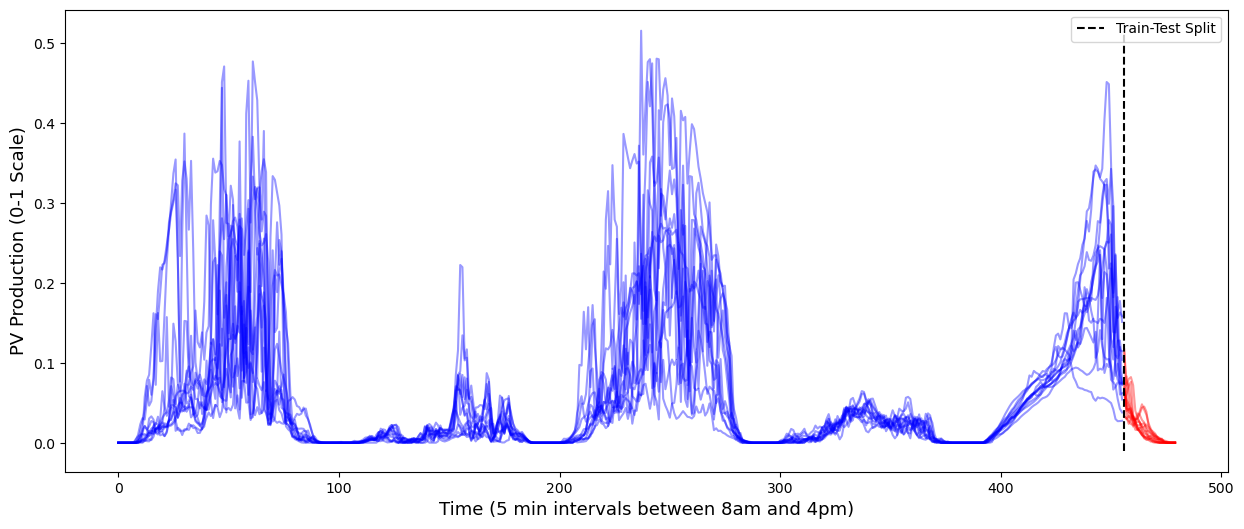

In [4]:
plot_train_test_split(y_train, y_test)

In [5]:
from kernels.quasi_periodic import generate_quasi_periodic
kernel = generate_quasi_periodic()

Iter 30/300 - Loss: -3.744
Iter 60/300 - Loss: -4.213
Iter 90/300 - Loss: -4.318
Iter 120/300 - Loss: -4.362
Iter 150/300 - Loss: -4.386
Iter 180/300 - Loss: -4.401
Iter 210/300 - Loss: -4.411
Iter 240/300 - Loss: -4.418
Iter 270/300 - Loss: -4.424
Iter 300/300 - Loss: -4.429


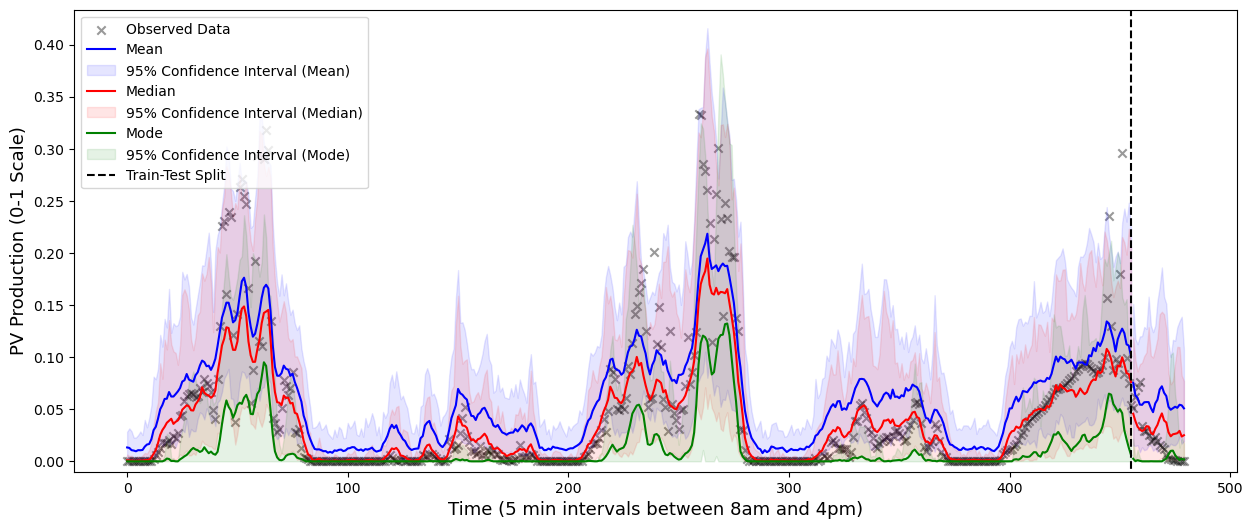

Iter 30/300 - Loss: -2.931
Iter 60/300 - Loss: -3.535
Iter 90/300 - Loss: -3.634
Iter 120/300 - Loss: -3.675
Iter 150/300 - Loss: -3.694
Iter 180/300 - Loss: -3.706
Iter 210/300 - Loss: -3.715
Iter 240/300 - Loss: -3.722
Iter 270/300 - Loss: -3.729
Iter 300/300 - Loss: -3.735


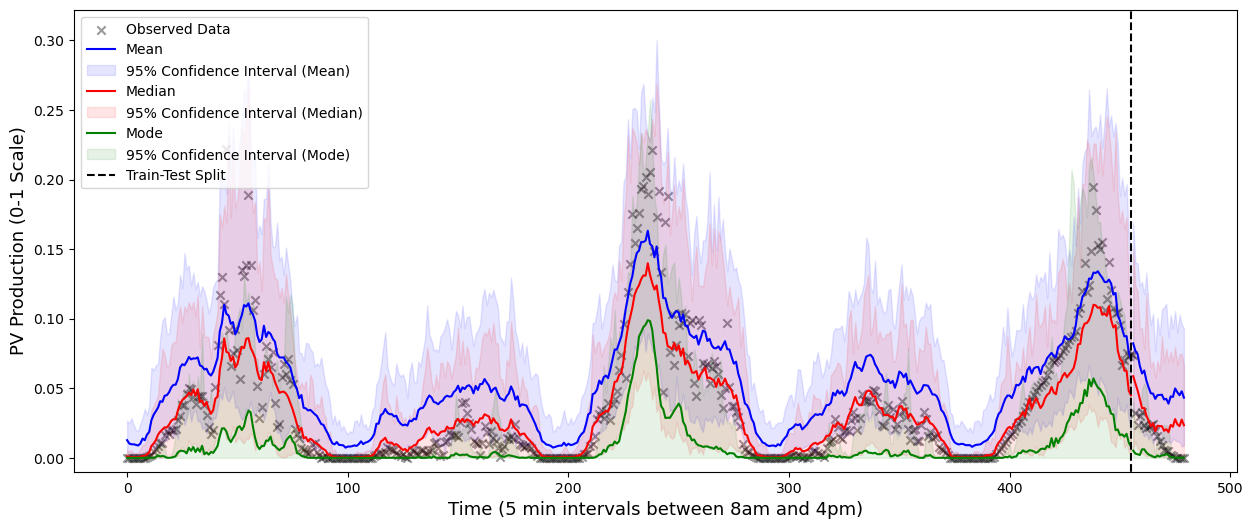

Iter 30/300 - Loss: -2.713
Iter 60/300 - Loss: -3.311
Iter 90/300 - Loss: -3.409
Iter 120/300 - Loss: -3.451
Iter 150/300 - Loss: -3.472
Iter 180/300 - Loss: -3.486
Iter 210/300 - Loss: -3.495
Iter 240/300 - Loss: -3.503
Iter 270/300 - Loss: -3.510
Iter 300/300 - Loss: -3.516


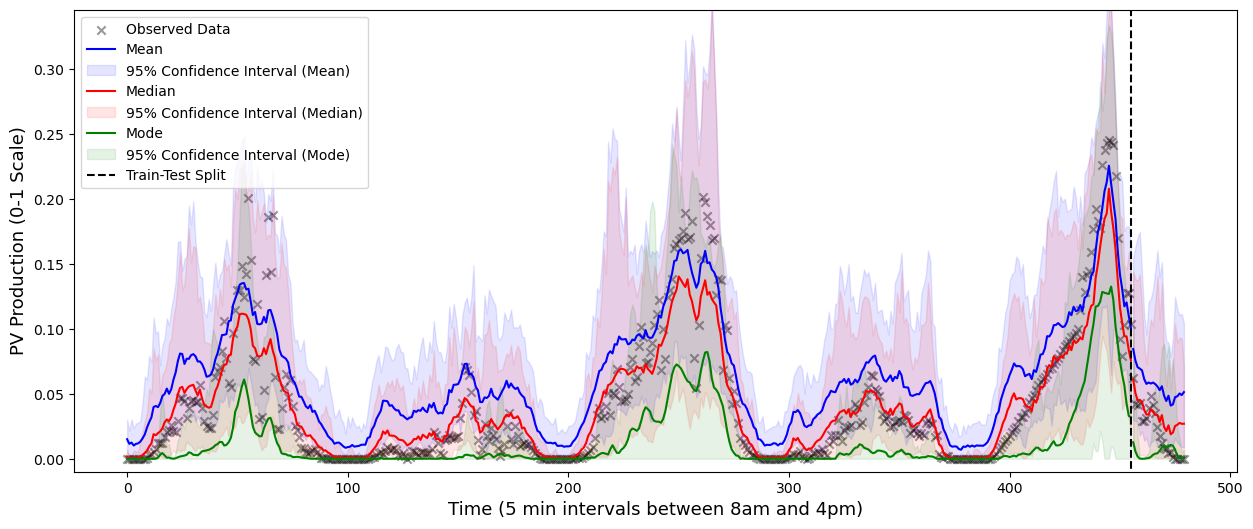

Iter 30/300 - Loss: -2.801
Iter 60/300 - Loss: -3.303
Iter 90/300 - Loss: -3.393
Iter 120/300 - Loss: -3.430
Iter 150/300 - Loss: -3.449
Iter 180/300 - Loss: -3.464
Iter 210/300 - Loss: -3.473
Iter 240/300 - Loss: -3.480
Iter 270/300 - Loss: -3.486
Iter 300/300 - Loss: -3.492


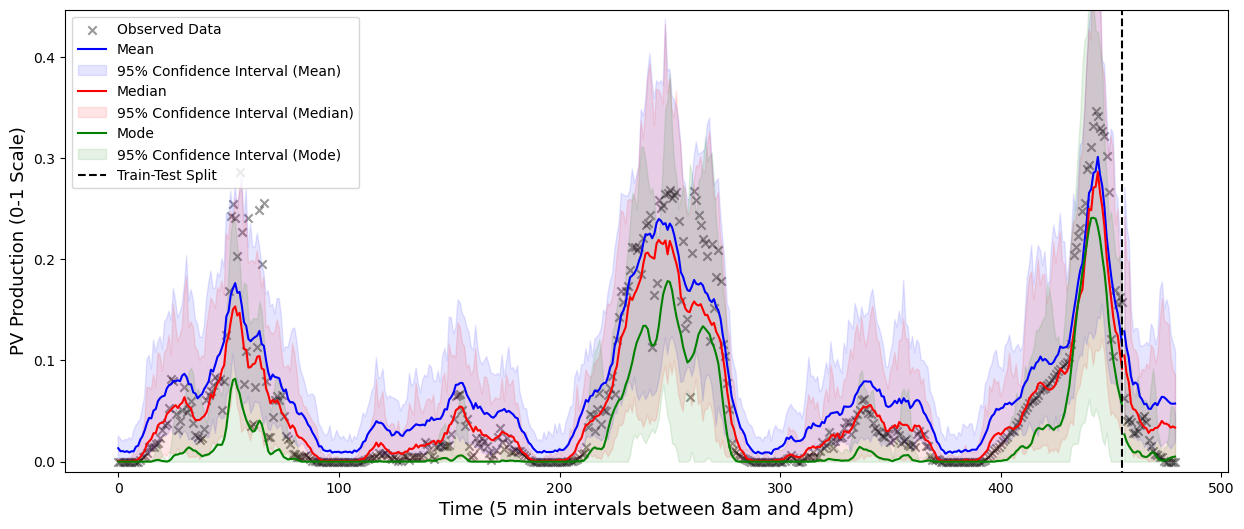

Iter 30/300 - Loss: -2.786
Iter 60/300 - Loss: -3.200
Iter 90/300 - Loss: -3.285
Iter 120/300 - Loss: -3.323
Iter 150/300 - Loss: -3.344
Iter 180/300 - Loss: -3.356
Iter 210/300 - Loss: -3.363
Iter 240/300 - Loss: -3.368
Iter 270/300 - Loss: -3.373
Iter 300/300 - Loss: -3.377


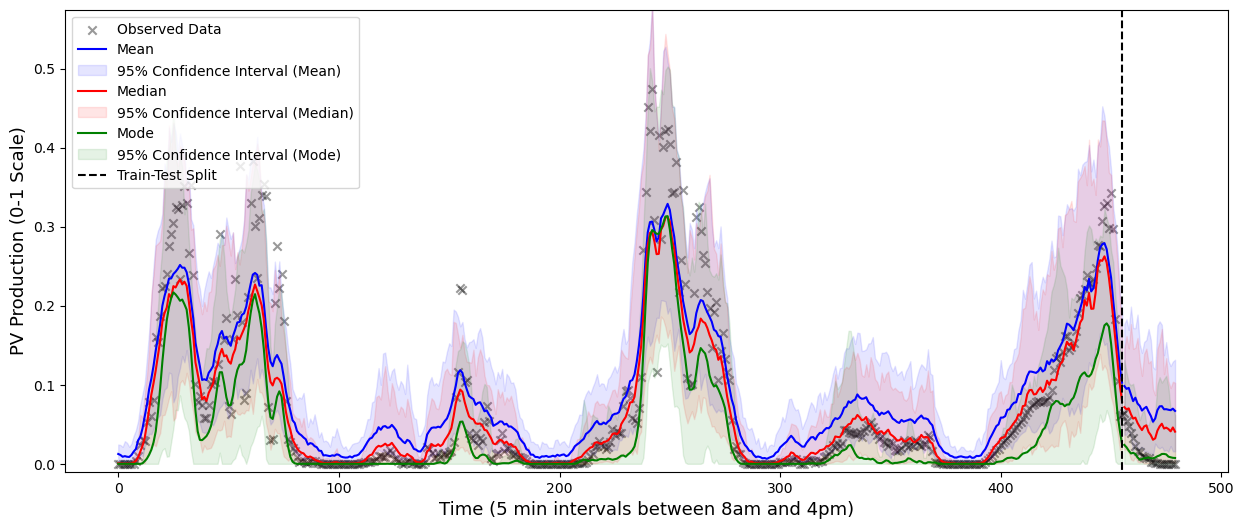

Iter 30/300 - Loss: -2.627
Iter 60/300 - Loss: -3.161


In [6]:
jitter = 1e-4
config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

for idx in range(y_train.size(1)):
    
  
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': kernel,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=10,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1,  verbose=True)    
    
    preds = model_beta.predict(X)
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], pred_type='all')